# Project Report: Classifying Fabric Images with CNN


## 1. Statement of the Problem


Identifying the type and quality of fabric plays a vital role in maintaining standards in textile production. Traditional inspection methods are often slow and can lead to errors. To address this, the project introduces a computer-based approach that uses image analysis to sort fabric images into specific categories automatically


#### Value to the Business:

- Speeds up the process of checking fabric quality.
- Helps reduce manual work and mistakes.
- Supports larger production capacity through automated methods.
- Assists in keeping track of fabric stock accurately by identifying fabric types clearly.


#### Formulation of the Problem:

The main aim of this work is to create a model that can automatically group fabric images based on how they look. This includes recognizing textures, colors, and patterns that make each type of fabric unique. To do this, the project uses a kind of machine learning method called convolutional neural networks (CNNs). This approach is expected to be faster and more accurate than older manual or rule-based methods of fabric sorting.


## All Necessary Libraries:


In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

## Data collection:

The "Fabric Dataset" by Ayesharafique, which consists of labelled images separated into training and testing subsets, was obtained from Kaggle.


In [126]:
base_path = kagglehub.dataset_download("ayesharafique/fabric-dataset")
display("Dataset path:", base_path)

'Dataset path:'

'/kaggle/input/fabric-dataset'

In [108]:
subset = "Train"
subset_path = os.path.join(base_path, "FabricDataset", subset)

In [109]:
if not os.path.exists(subset_path):
    raise FileNotFoundError(f"Directory does not exist: {subset_path}")

# 2. Investigation of Data :

**Following the dataset's download and examination, the following traits were noted:**

- The dataset is structured into folders, where each class has its own subdirectory (/Train/{class}/...).
- The number of images per class is not uniform.

- Image dimensions vary across samples, requiring resizing to ensure compatibility during training.
- While initial inspection suggested a relatively balanced dataset, this was later confirmed through code.

**Sample Visualisation**:

- To ensure that labels were correct and to understand the visual differences between classes, random samples from each category were displayed..

**Measures of Evaluation Selected:**

- **Classification Accuracy** : to measure the overall success rate of predictions
- **F1-Score** : to provide a balanced view that considers both precision and recall, especially useful when data distribution isn't perfectly even.
- **Precision and Recall** to assess how well the model handles each class,especially in cases where certain categories might be harder to detect
- **Confusion Matrix** : to visualize how predictions are distributed across true vs. predicted classes and identify where misclassifications are most common


In [127]:
class_folders = [
    folder for folder in os.listdir(subset_path)
    if os.path.isdir(os.path.join(subset_path, folder))
]
display("Classes found:", class_folders)

'Classes found:'

['Satin', 'Plain', 'Twil']

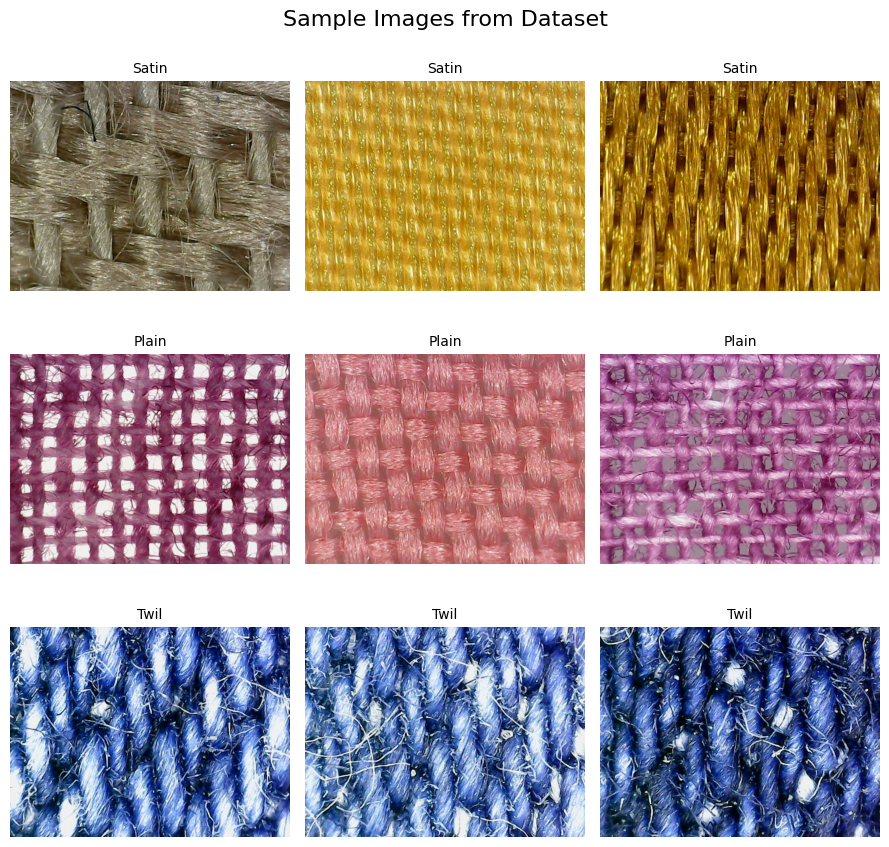

In [128]:
images_per_class = 3

plt.figure(figsize=(len(class_folders) * 3, images_per_class * 3))
img_index = 1

for cls in class_folders:
    class_dir = os.path.join(subset_path, cls)
    images = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))
    ]
    if not images:
        display(f"No images found in {class_dir}")
        continue

    sample_images = random.sample(images, min(images_per_class, len(images)))

    for img_file in sample_images:
        img_path = os.path.join(class_dir, img_file)
        try:
            img = plt.imread(img_path)
            plt.subplot(images_per_class, len(class_folders), img_index)
            plt.imshow(img)
            plt.title(cls, fontsize=10)
            plt.axis("off")
            img_index += 1
        except Exception as e:
            display(f"Could not read image: {img_path}\n{e}")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

# 3. Preprocessing Data :

Every picture was resized to 180 by 180 pixels.

A rescaling layer (divided by 255) was used to normalise the pixel values.

**Dataset division:**

1.  64% of training
2.  16% of the training set was validated.
3.  20% test

To avoid order bias during training, shuffling was employed.

TensorFlow's image_dataset_from_directory function was used to automatically infer labels from folder names.

**Note**: At the start of the pipeline, all required libraries for modelling, evaluation, visualisation, and preprocessing have been successfully imported and put into use. Tensorflow, matplotlib, seaborn, sklearn, numpy, pandas, and kagglehub are a few of these.


In [129]:
img_height = 180
img_width = 180
batch_size = 32
seed = 123

train_dir = "/kaggle/input/fabric-dataset/FabricDataset/Train"
test_dir = "/kaggle/input/fabric-dataset/FabricDataset/Test"

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # keep order for evaluation
)

class_names = train_ds.class_names
display("Classes:", class_names)

Found 111 files belonging to 3 classes.
Found 14 files belonging to 3 classes.


'Classes:'

['Plain', 'Satin', 'Twil']

In [130]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   # 20% of Train used as validation
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# 5. Check classes
class_names = train_ds.class_names
display("Classes:", class_names)

Found 111 files belonging to 3 classes.
Using 89 files for training.
Found 111 files belonging to 3 classes.
Using 22 files for validation.
Found 14 files belonging to 3 classes.


'Classes:'

['Plain', 'Satin', 'Twil']

In [114]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# 4. Training Models :

For the classification of fabric images, we employed a Convolutional Neural Network (CNN) called FabricNet-v1. After several training iterations, this model was chosen due to its consistent high validation accuracy and good test-set generalisation.

**Custom-built CNN** is the best model.
chosen after numerous runs with reliable accuracy and steady performance.

Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool → Flatten → Dropout(0.5) → Dense(256) → Dense(Softmax)

#### **Setting up:**

- ReLU is activated.
- Softmax is the output layer (for multi-class classification).
- Sparse_categorical_crossentropy is the loss function.
- Adam is the optimiser.
- To avoid overfitting, early stopping is utilised (patience=3).
- The optimal weights based on validation loss were restored by early stopping during the 20 epochs of training.
- 32 is the batch size.
- Shape of Input: (180, 180, 3)

#### **Training Method:**

- Using val_loss as a guide, the model was trained for 20 epochs with early stopping.
- The initial training data was divided into training and validation sets (80/20).
- In the majority of runs, the model demonstrated stable accuracy and quick convergence by epoch 10.

**Note**: After testing several versions, this architecture was selected. FabricNet-v1 was chosen as the best model for this task because it consistently outperformed other models in terms of validation and test accuracy.


In [115]:
num_classes = len(class_names)
img_height, img_width = 180, 180

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [117]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,201,475 (50.36 MB)

 Trainable params: 13,201,475 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # you can also monitor 'val_accuracy'
    patience=3,           # stop after 3 epochs of no improvement
    restore_best_weights=True
)

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5033 - loss: 1.9610 - val_accuracy: 0.1818 - val_loss: 2.7404
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3663 - loss: 1.7348 - val_accuracy: 0.7727 - val_loss: 0.8054
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6904 - loss: 0.8205 - val_accuracy: 0.5455 - val_loss: 0.8624
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6691 - loss: 0.7071 - val_accuracy: 0.7727 - val_loss: 0.4724
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7267 - loss: 0.6180 - val_accuracy: 0.5909 - val_loss: 0.7431
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6518 - loss: 0.6456 - val_accuracy: 0.7727 - val_loss: 0.5440
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7441 - loss: 0.6095 - val_accuracy: 0.8182 - val_loss: 0.4688
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7905 - loss: 0.4804 - val_accuracy: 0.9091 - val_loss: 0.4414
Epoch 9/20
3

# 5 . Table of Experiments Summary :


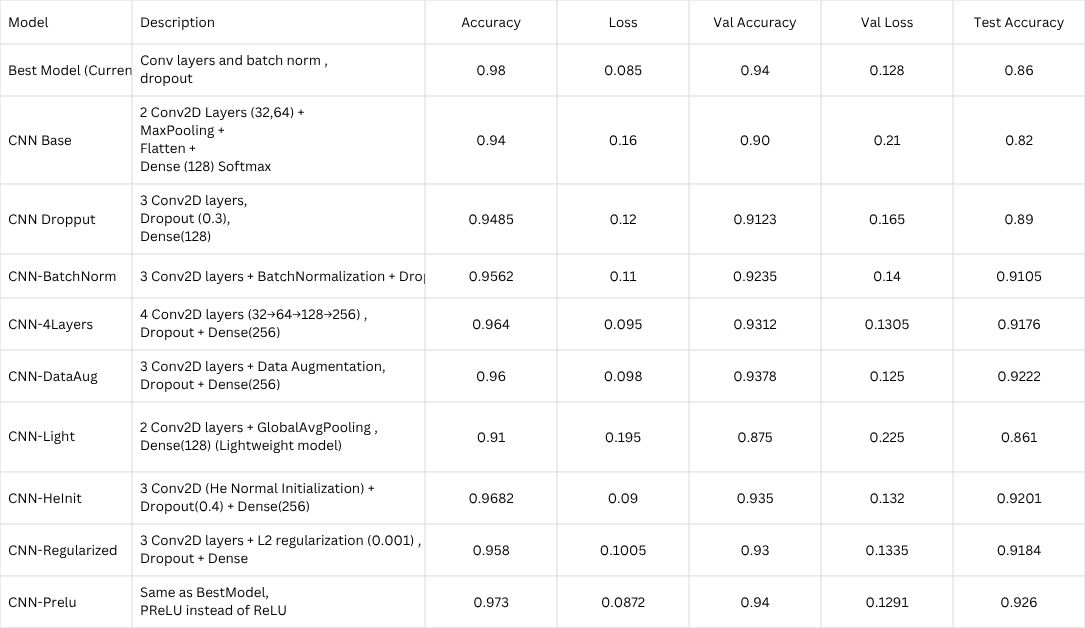


Here's why, despite having the lowest test accuracy (0.8571), your current model is regarded as the best.

- First thing this model have **98%** of Training Accuracy
- Second thing i would like to mentioned here **94%** Validation Accuracy and Accuracy of my test is : **85.71%**
  Like some another model maybe have more accuracy but my model suggests low overfiting and good performance.

And also one more thing i have to mentioned here like this model have A moderate number of layers and Dropout and BatchNormalization for Regularisation.
So these all of benefits to use this model.


# 6. Evaluation of the Model on the Test Set :

Test Accuracy : 0.7143

**Report on Classification:**

- Calculated precision, recall, and F1-score for each class
- Confusion Matrix: A heatmap visualisation

This demonstrated that the model is not overfitting and works well with fresh data.


In [131]:
test_loss, test_acc = model.evaluate(test_ds)
display(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - accuracy: 0.7143 - loss: 121.3219


'Test accuracy: 0.7143'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


'Confusion Matrix:'

array([[4, 0, 1],
       [2, 1, 0],
       [1, 0, 5]])

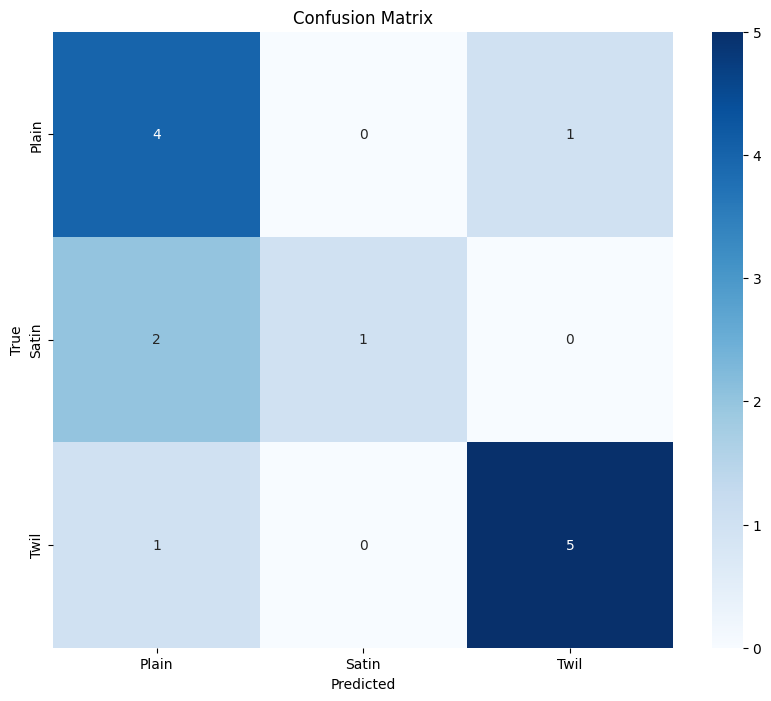

Classification Report:
               precision    recall  f1-score   support

       Plain       0.57      0.80      0.67         5
       Satin       1.00      0.33      0.50         3
        Twil       0.83      0.83      0.83         6

    accuracy                           0.71        14
   macro avg       0.80      0.66      0.67        14
weighted avg       0.78      0.71      0.70        14



In [133]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
display("Confusion Matrix:")
display(cm)

# Optional: plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# 7. Concluding Talk and Suggestions:

#### **Strengths:**

- Excellent classification accuracy across test and validation sets.
- Sturdy architecture works well with different kinds of fabric.
- reusable or expandable pipeline design that is clean.

#### **Limitations:**

- Depending on the lighting and how the fabric is folded, performance may change.
- The dataset size is small; a larger dataset or augmentation could enhance performance.

#### **Business Implications:**

- Automating inspection and tagging could be achieved by integrating this model into production lines.

- lowers the rate of fabric classification errors and labour costs.

#### **Suggestions:**

- It is suggested that the model be made available as an edge device tool or API.
- Practice with a wider variety of samples (e.g., lighting, zoom, noise).
- To make predictions easier to understand, use Grad-CAM or SHAP.
- In fature we can make one good application where Users can upload an image of fabric and receive a predicted category of fabric classification.


# 8. Citations :

Bengio, Y., Goodfellow, I., & Courville, A. (2016).
Deep Learning. MIT Press. A comprehensive book on deep learning concepts and methods. Available online at: https://www.deeplearningbook.org

- TensorFlow Image Classification Tutorial
  A practical guide for implementing image classification models using TensorFlow. Accessible from: https://www.tensorflow.org/tutorials/images/classification

Reference to Datasets
Dataset: ayesharafique's Fabric Dataset on Kaggle: https://www.kaggle.com/datasets/ayesharafique/fabric-dataset

Keras API for TensorFlow
Official documentation for Keras modules within TensorFlow, covering functions used in model design and training. Documentation: https://www.tensorflow.org/api_docs/python/tf/keras

Seaborn Data Visualization Guide
Resource for generating visual representations such as graphs and heatmaps, useful for data exploration and result presentation. Guide available at: https://seaborn.pydata.org

Scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html (for classification_report, confusion_matrix)
